In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from climakitae.core.data_interface import (
    get_data,
)
from renewable_data_load import *

import dask
dask.config.set(scheduler='threads', num_workers=10)  # Adjust num_workers to your CPU cores

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [21]:
resource = "windpower"
module = "onshore"
domain = "d02"
variable = "cf"
frequency = "day"

future_gwl = 2.0
reference_gwl = 0.8

simulation = "mpi-esm1-2-hr"

simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", 'ec-earth3',]


In [22]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']

In [23]:
combos = [("pv", "utility",'d02'), ("windpower", "onshore",'d02'), ("windpower", "offshore",'d03')]

Processing Resource: pv, Module: utility, Simulation: mpi-esm1-2-hr
Processing Resource: pv, Module: utility, Simulation: miroc6
Processing Resource: pv, Module: utility, Simulation: taiesm1
Processing Resource: pv, Module: utility, Simulation: ec-earth3
Processing Resource: windpower, Module: onshore, Simulation: mpi-esm1-2-hr
Processing Resource: windpower, Module: onshore, Simulation: miroc6
Processing Resource: windpower, Module: onshore, Simulation: taiesm1
Processing Resource: windpower, Module: onshore, Simulation: ec-earth3
Processing Resource: windpower, Module: offshore, Simulation: mpi-esm1-2-hr
Processing Resource: windpower, Module: offshore, Simulation: miroc6
Processing Resource: windpower, Module: offshore, Simulation: taiesm1


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_26233/1909538936.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))  # open matplotlib figure


Processing Resource: windpower, Module: offshore, Simulation: ec-earth3


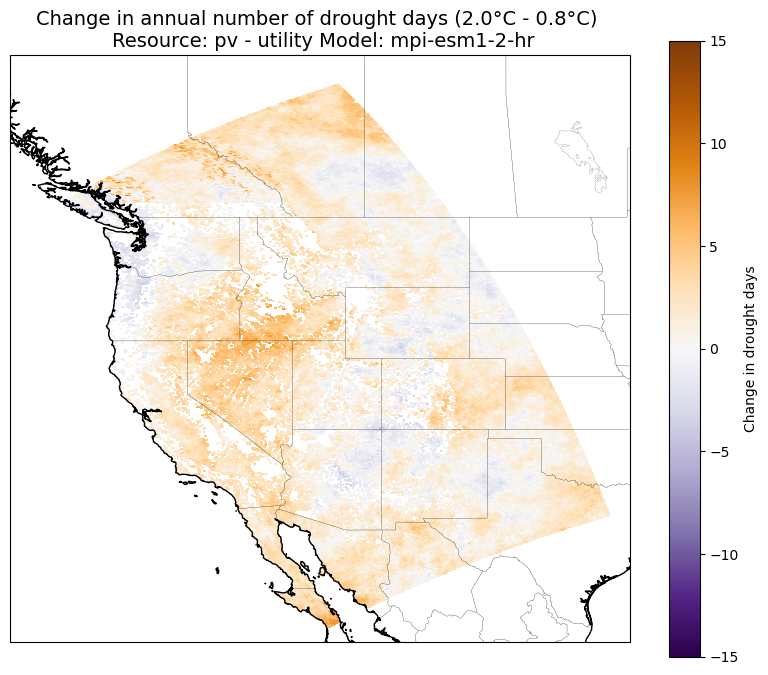

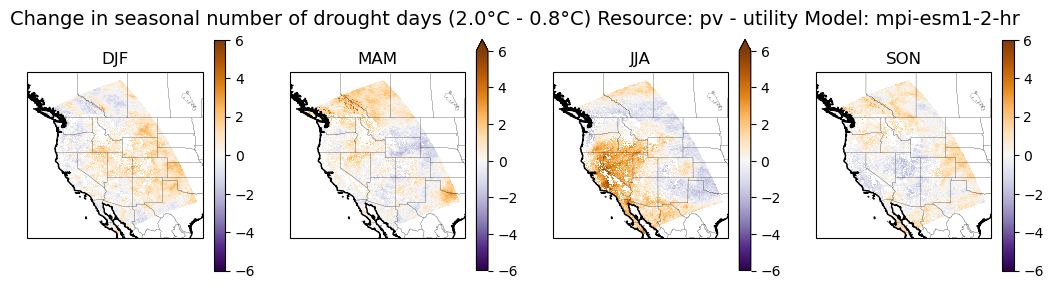

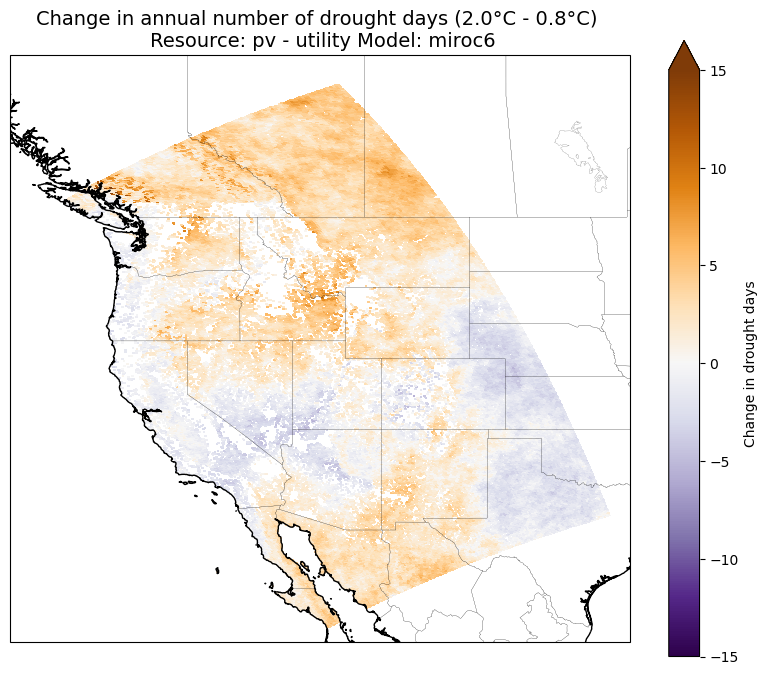

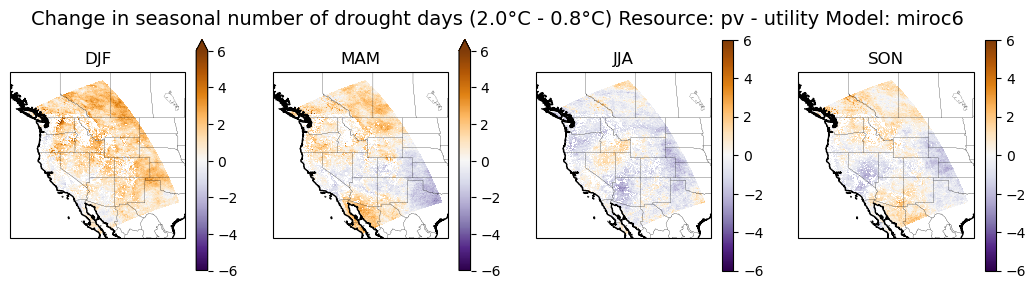

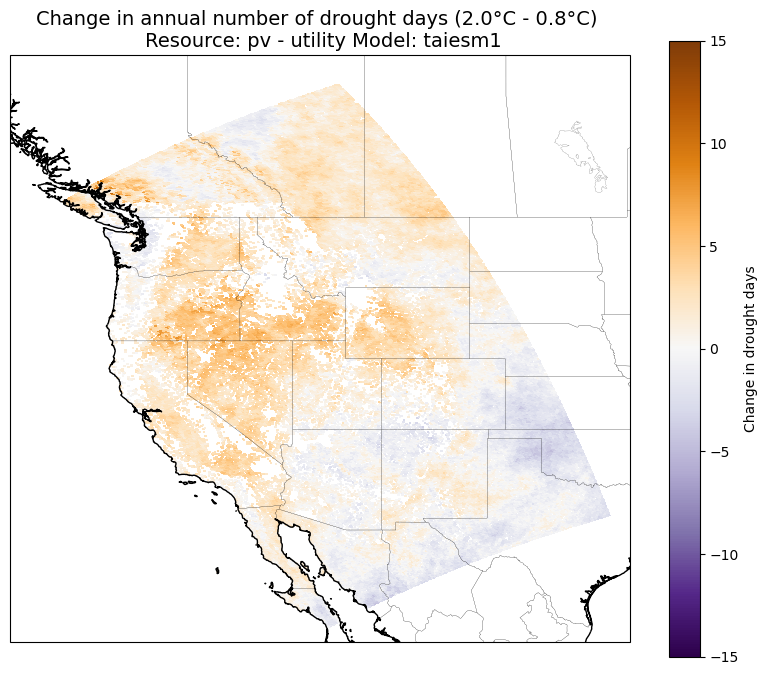

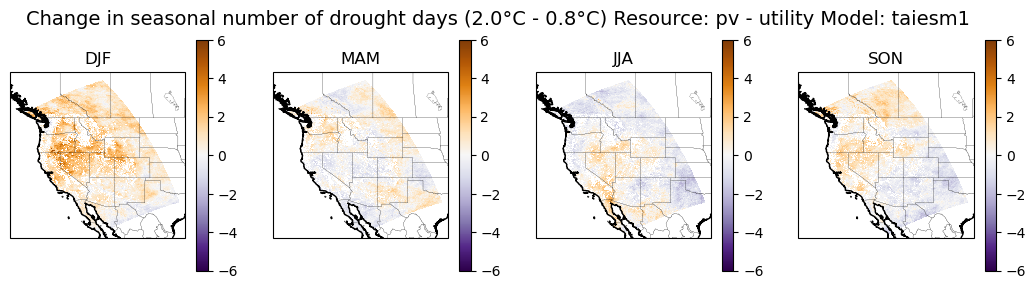

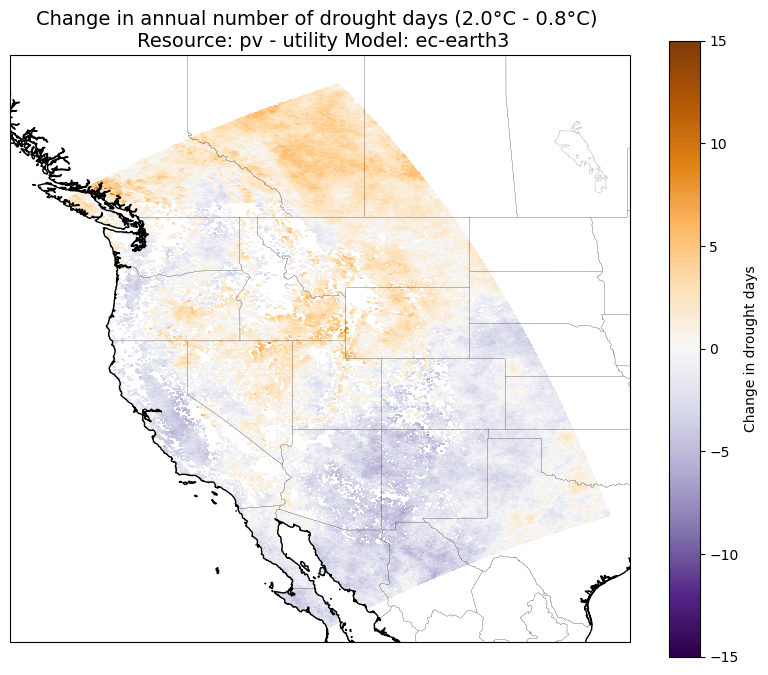

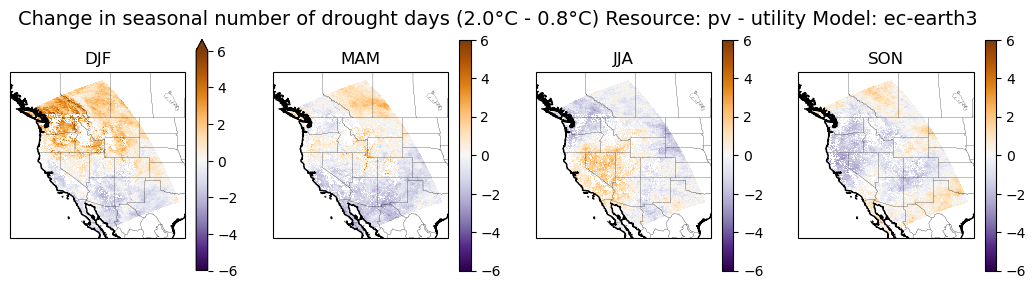

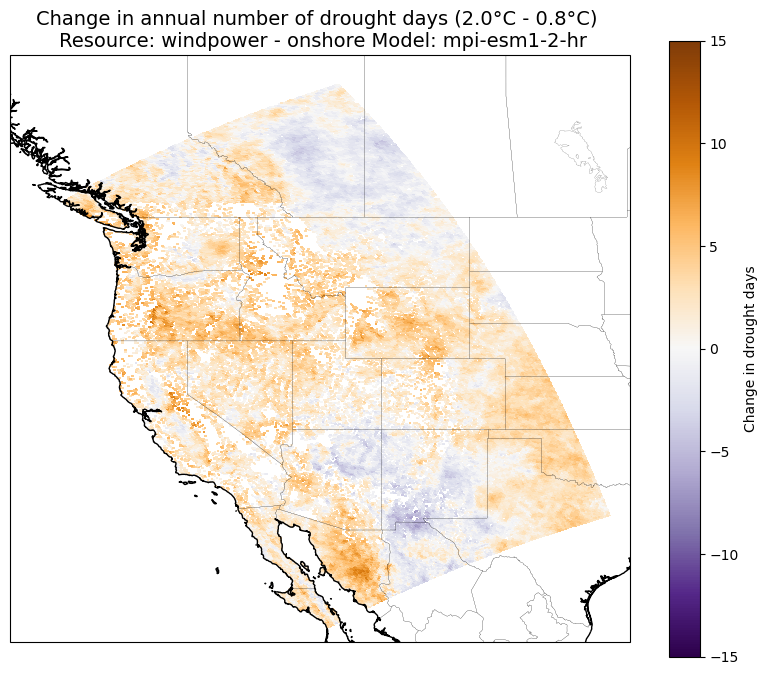

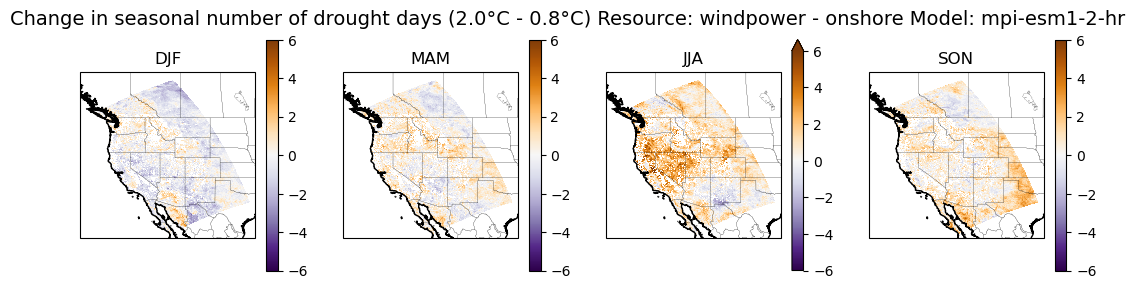

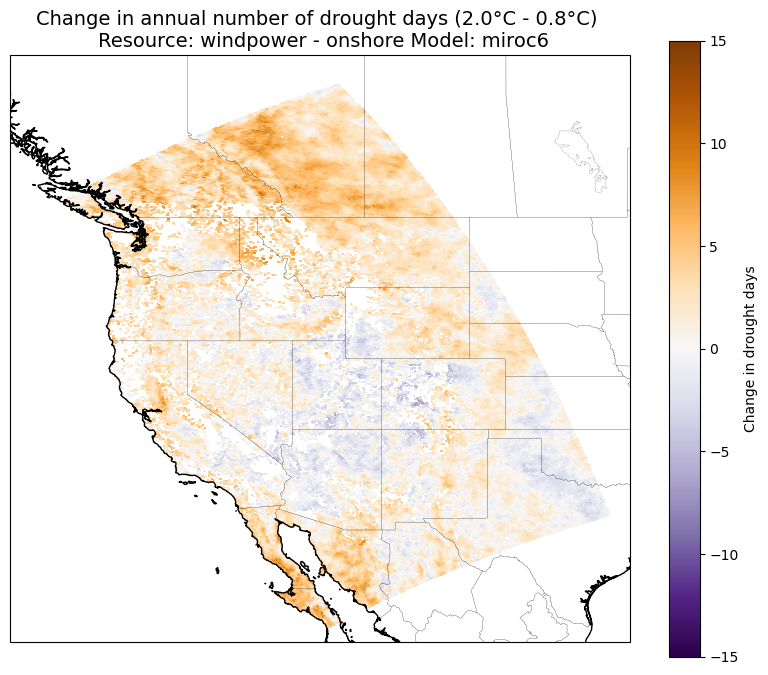

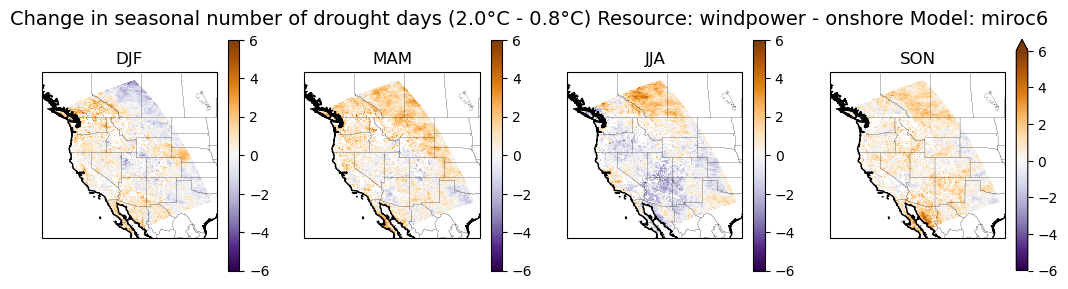

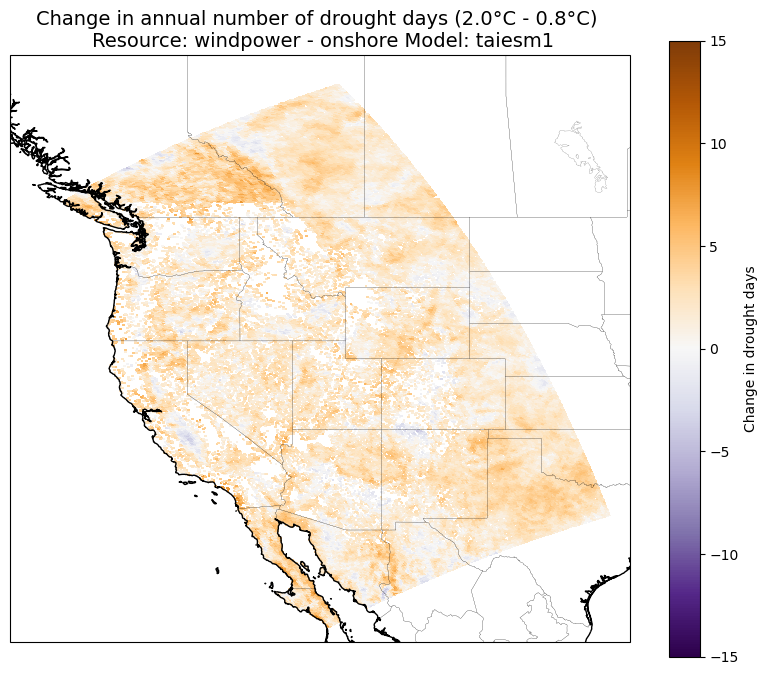

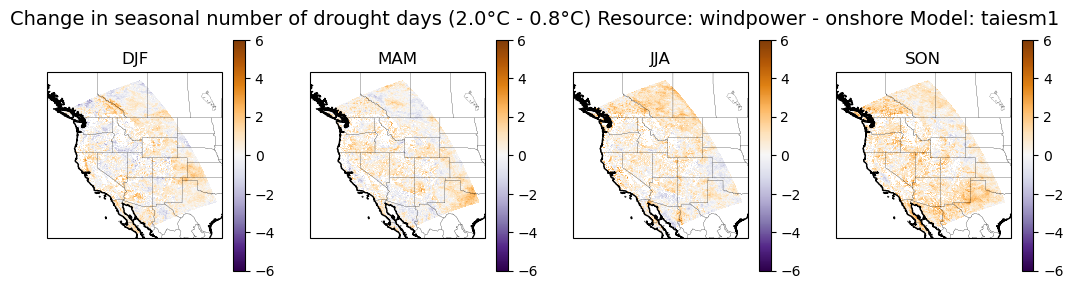

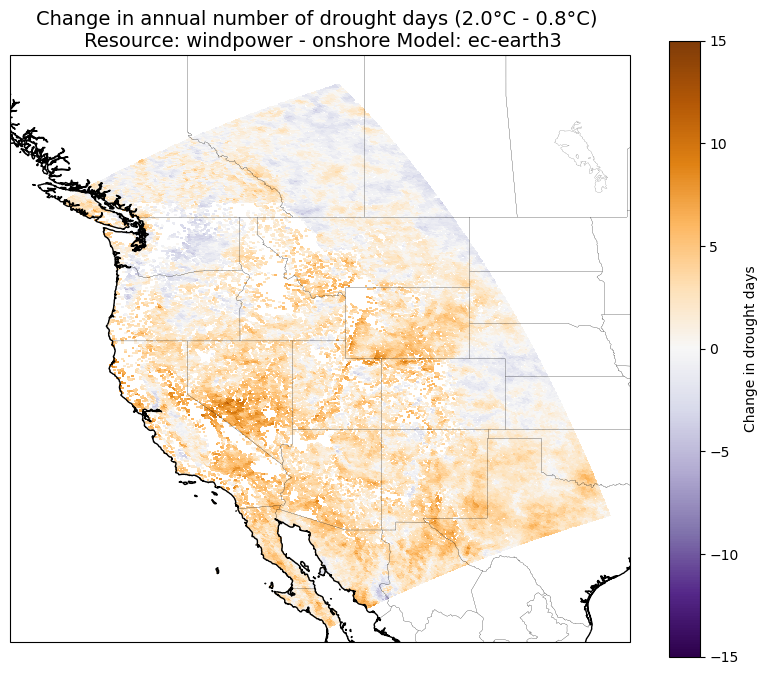

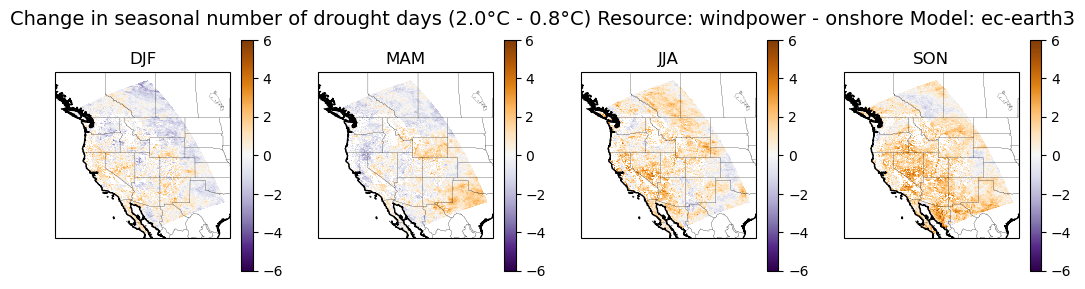

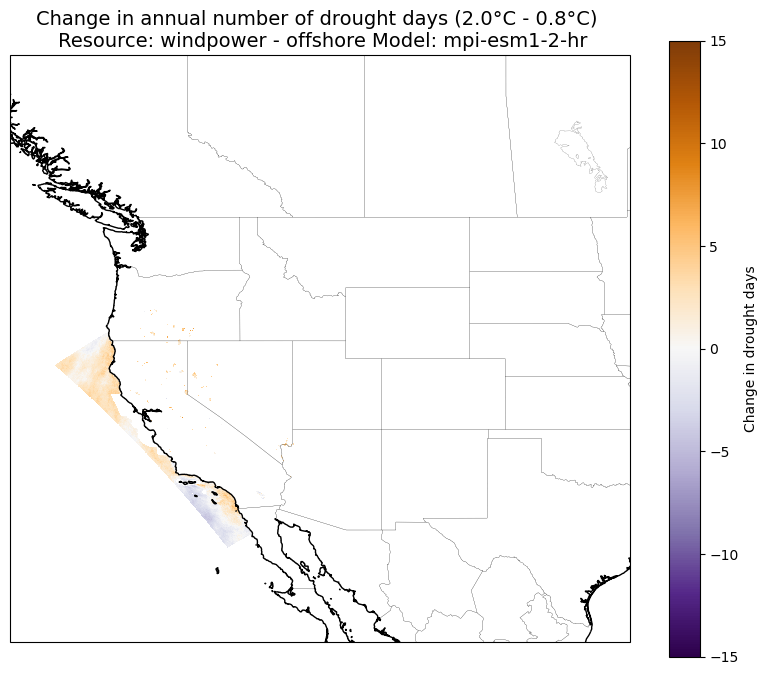

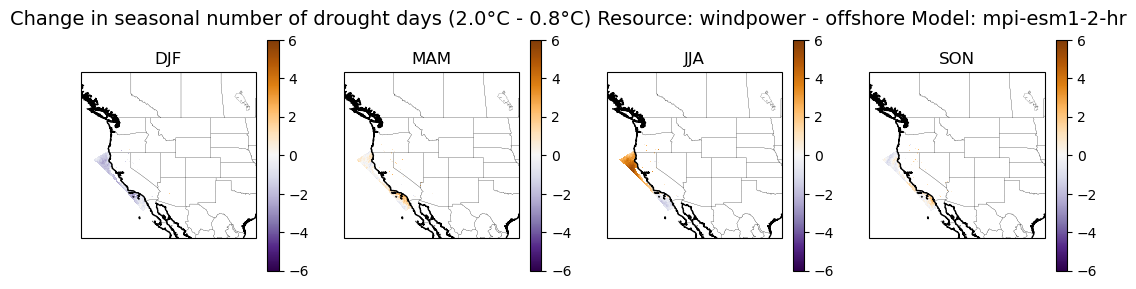

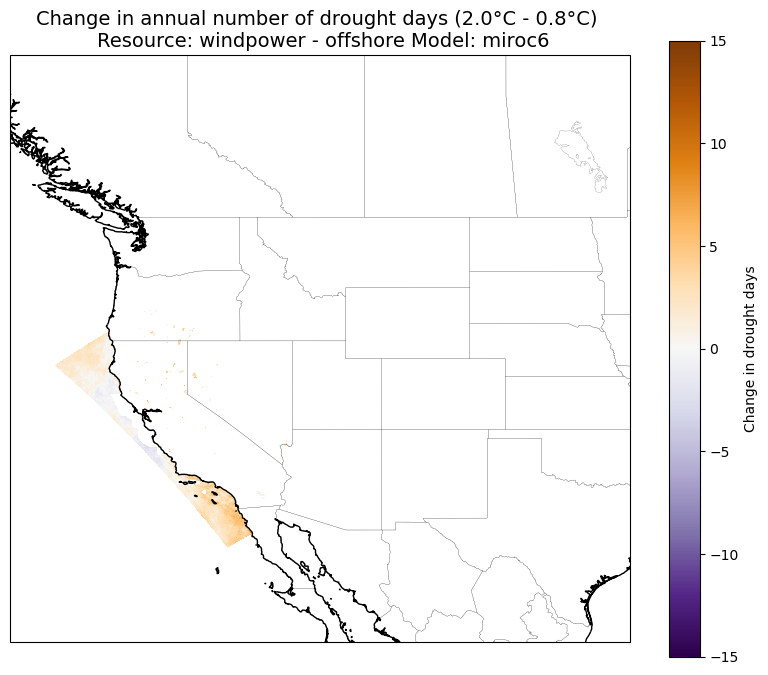

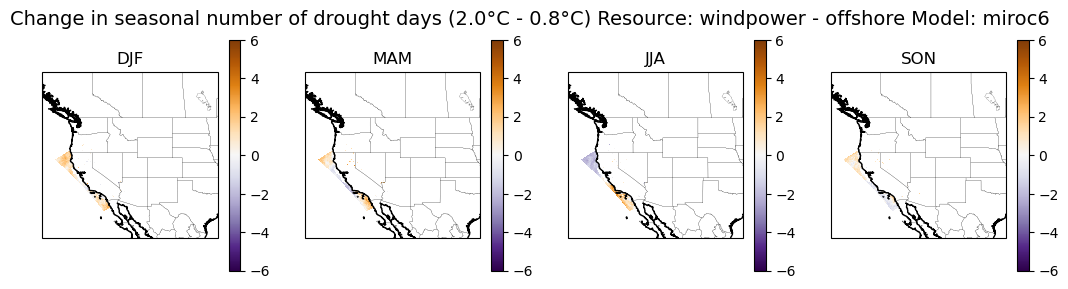

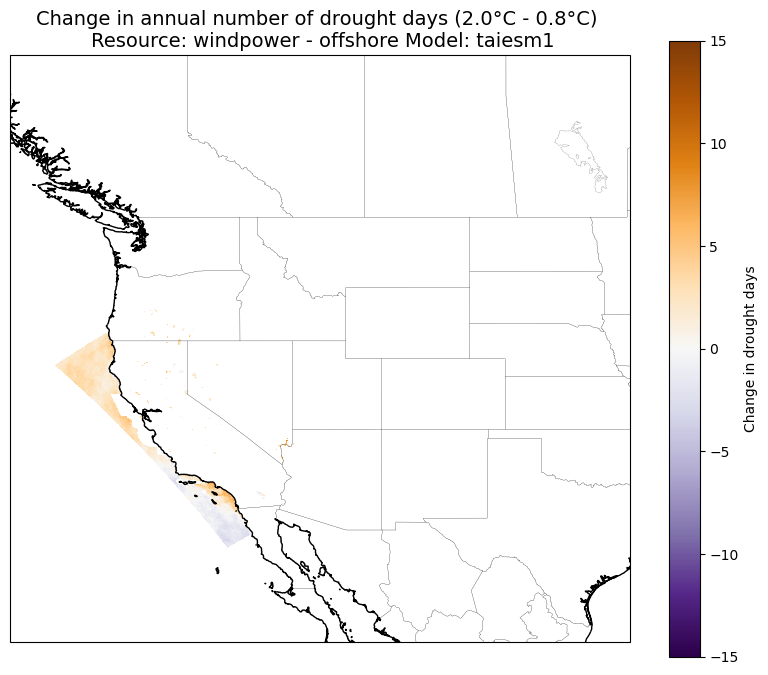

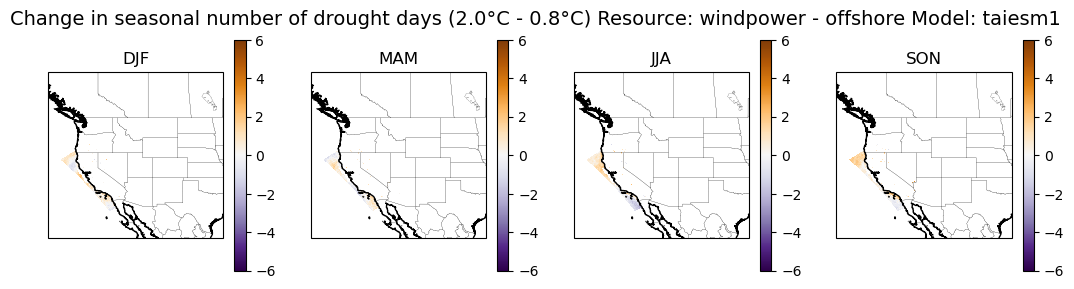

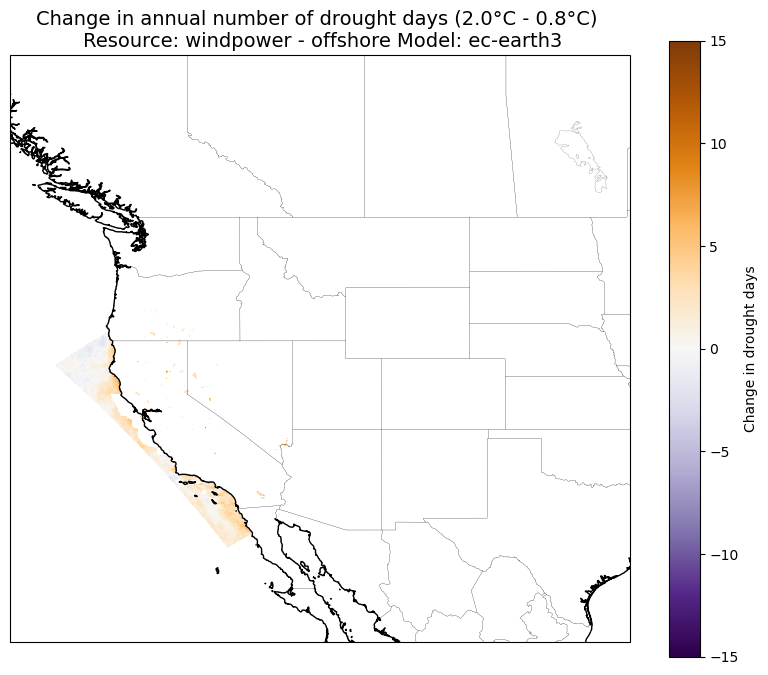

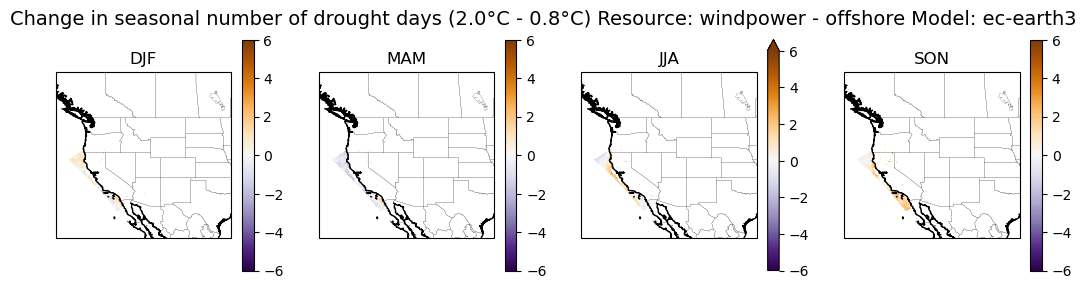

In [24]:
for resource, module, domain in combos:
    for simulation in simulations:

        print(f"Processing Resource: {resource}, Module: {module}, Simulation: {simulation}")
        fut_drought_stats_file = f"/Users/work/Code/renewable-analysis/data/drought_stats/{resource}_{module}_{domain}_{variable}_{simulation}_gwl2.0_drought_mask_metrics.nc"
        ref_drought_stats_file = f"/Users/work/Code/renewable-analysis/data/drought_stats/{resource}_{module}_{domain}_{variable}_{simulation}_gwl0.8_drought_mask_metrics.nc"

        # open zarr datasets
        ref_drought_stats = xr.open_zarr(ref_drought_stats_file, consolidated=True)
        fut_drought_stats = xr.open_zarr(fut_drought_stats_file, consolidated=True)

        ref_annual_days = ref_drought_stats.duration.resample(time='YE').sum(dim='time').mean(dim='time')
        fut_annual_days = fut_drought_stats.duration.resample(time='YE').sum(dim='time').mean(dim='time')
        delta_annual_mean = (fut_annual_days - ref_annual_days)
        delta_annual_mean = delta_annual_mean.where(delta_annual_mean != 0).compute()

        fut_seasonal_mean = fut_drought_stats.duration.resample(time='QS-DEC').sum().groupby('time.season').mean()
        ref_seasonal_mean = ref_drought_stats.duration.resample(time='QS-DEC').sum().groupby('time.season').mean()
        delta_seasonal_mean = fut_seasonal_mean - ref_seasonal_mean

        # set zeros to nan
        delta_seasonal_mean = delta_seasonal_mean.where(delta_seasonal_mean != 0).compute()


        fig = plt.figure(figsize=(10, 8))  # open matplotlib figure
        ax = plt.axes(projection=ccrs.PlateCarree())
        delta_annual_mean.plot(
            ax=ax,
            x="lon",
            y="lat",
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"label": "Change in drought days"},
            cmap="PuOr_r",
            vmin=-15,
            vmax=15
            )

        ax.set_extent([-130, -95, 25, 57])

        ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black", linewidth=0.1)
        ax.add_feature(cfeature.COASTLINE.with_scale("10m"), edgecolor="black")

        plt.title(f"Change in annual number of drought days (2.0°C - 0.8°C) \n Resource: {resource} - {module} Model: {simulation}", fontsize=14)
        plt.savefig(f"figures/large_scale_cf_change_{resource}_{module}_{future_gwl}C_minus_{reference_gwl}C_{simulation}_annual.png", dpi=300, bbox_inches='tight')

        fig, axes = plt.subplots(
            1, 4, figsize=(13, 3), subplot_kw={"projection": ccrs.PlateCarree()}
        )
        for ax, season in zip(axes.flatten(), seasons, strict=False):
            delta_seasonal_mean.sel(season=season).plot(
                ax=ax,
                x="lon",
                y="lat",
                transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": None},
                cmap="PuOr_r",
                vmin=-6,
                vmax=6
            )
            ax.set_title(season)
            ax.set_extent([-130, -95, 25, 57])
            ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black", linewidth=0.1)
            ax.add_feature(cfeature.COASTLINE.with_scale("10m"), edgecolor="black")
        # set title
        fig.suptitle(f"Change in seasonal number of drought days (2.0°C - 0.8°C) Resource: {resource} - {module} Model: {simulation}", fontsize=14)
        plt.savefig(f"figures/large_scale_cf_change_{resource}_{module}_{future_gwl}C_minus_{reference_gwl}C_{simulation}_seasonal.png", dpi=300, bbox_inches='tight')